In [10]:
# モジュールのインポート
import math
import pandas as pd
import seaborn as sns
# Ridge Regressionモデルクラスの読み込み
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
# scikit-learnの準備
from sklearn.model_selection import train_test_split
# 線形回帰で学習
from sklearn import linear_model

In [2]:
#データの読み込みと観測
df = pd.read_csv('./data/train.csv')
df.head()

,rent_price,house_area,year_from_built,distance,built_date,balcony_area,house_structure,floor,total_floor
0,81000.0,22.627647,21,360.0,2001-04-01,0.0,RC,4.0,10.0
1,119000.0,29.487423,11,720.0,2011-03-01,0.0,RC,3.0,10.0
2,65000.0,13.960667,32,640.0,1990-03-01,0.0,RC,3.0,6.0
3,230000.0,79.860208,13,480.0,2009-03-01,0.0,RC,15.0,29.0
4,102000.0,34.471313,23,320.0,1999-05-01,0.0,RC,2.0,7.0


## 前処理
- 欠損値の有無
- 価格に影響のある要素を探索

In [5]:
## 欠損値の有無
df.isnull().sum()

rent_price         0
house_area         0
year_from_built    0
distance           0
built_date         0
balcony_area       0
house_structure    0
floor              0
total_floor        0
dtype: int64

In [7]:
## 要約統計量・相関関係用のデータフレーム
## 質的データは扱えない為
df_ryouteki = df[['rent_price','house_area','year_from_built','distance','balcony_area','floor','total_floor']]
df_ryouteki

,rent_price,house_area,year_from_built,distance,balcony_area,floor,total_floor
0,81000.0,22.627647,21,360.0,0.0,4.0,10.0
1,119000.0,29.487423,11,720.0,0.0,3.0,10.0
2,65000.0,13.960667,32,640.0,0.0,3.0,6.0
3,230000.0,79.860208,13,480.0,0.0,15.0,29.0
4,102000.0,34.471313,23,320.0,0.0,2.0,7.0
...,...,...,...,...,...,...,...
7491,122000.0,33.846305,5,800.0,0.0,1.0,7.0
7492,148000.0,34.162131,8,480.0,0.0,11.0,13.0
7493,156000.0,42.661838,7,240.0,0.0,3.0,14.0
7494,80000.0,12.061398,15,2160.0,0.0,6.0,8.0


In [8]:
#要約統計量
#各カラムの統計量を算出
df_ryouteki.describe()

,rent_price,house_area,year_from_built,distance,balcony_area,floor,total_floor
count,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000,7496.000000
mean,107709.002401,31.895495,19.899413,671.691969,0.180027,5.417956,9.394744
std,37440.903554,15.286525,12.081026,321.754777,1.253041,3.366585,4.576573
min,36000.000000,3.841660,0.000000,39.000000,0.000000,1.000000,2.000000
25%,82000.000000,21.585432,11.000000,440.000000,0.000000,3.000000,6.000000
50%,96500.000000,27.829060,16.000000,640.000000,0.000000,5.000000,9.000000
75%,124000.000000,38.645629,30.000000,840.000000,0.000000,7.000000,12.000000
max,483000.000000,238.153798,60.000000,6740.000000,40.000000,37.000000,47.000000


In [11]:
#相関係数
cor = df_ryouteki.corr()
cor

,rent_price,house_area,year_from_built,distance,balcony_area,floor,total_floor
rent_price,1.000000,0.756981,-0.345099,-0.079748,0.074159,0.398635,0.478001
house_area,0.756981,1.000000,0.002970,-0.006251,0.057491,0.200240,0.248140
year_from_built,-0.345099,0.002970,1.000000,-0.022654,-0.035337,-0.203313,-0.309301
distance,-0.079748,-0.006251,-0.022654,1.000000,-0.027932,-0.166598,-0.249504
balcony_area,0.074159,0.057491,-0.035337,-0.027932,1.000000,0.044418,0.080385
floor,0.398635,0.200240,-0.203313,-0.166598,0.044418,1.000000,0.599256
total_floor,0.478001,0.248140,-0.309301,-0.249504,0.080385,0.599256,1.000000


<Axes: >

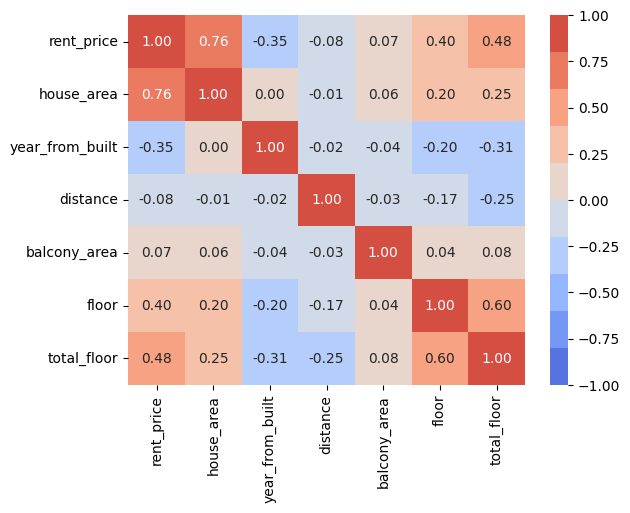

In [12]:
# 相関関係を可視化
sns.heatmap(cor, cmap= sns.color_palette('coolwarm', 10), annot=True,fmt='.2f', vmin = -1, vmax = 1)

## rent_priceに対しての相関の結果
- 正の相関
  - house_area
  - floor
  - total_floor
- 負の相関
  - year_from_built
- 影響が少ない項目
  - distance
  - balcony_area

## 機械学習

In [13]:
# 特徴量と正解データの設定

## 使いたい特徴量
feature_cols = ['house_area','distance','floor','total_floor','year_from_built']

## 予測したい列
target_col = 'rent_price'

x = df[feature_cols]
y = df[target_col]

In [14]:
# 訓練データとテストデータに8:2で分割
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# モデル学習
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
# 訓練データを用いた評価
print(model.score(X_train, y_train))
# テストデータを用いた評価
print(model.score(X_test, y_test))

0.7366149523232196
0.7612078327520752


In [17]:
# 学習したモデルを用いて予想
df['pred_rent_price'] = model.predict(x)
# 予想値と正解値のみ絞って比較
df[['rent_price','pred_rent_price']].head()

,rent_price,pred_rent_price
0,81000.0,90756.627684
1,119000.0,108918.411405
2,65000.0,59730.884819
3,230000.0,230392.138130
4,102000.0,103216.949397


In [18]:
# MAE(平均絶対値誤差)
# 正解値と予測値の差の絶対値で平均値を取ったもの

err_range = mean_absolute_error(df['rent_price'],df['pred_rent_price'])
print(f'誤差範囲は{math.floor(err_range):,.1f}円です。')

誤差範囲は14,119.0円です。


In [31]:
# フォームからデータを取得
area_form = 15
distance = 1500
year_from_built = 20

# カラムデータを作成
data = {'house_area': [area_form],
        'distance': [distance],
		'floor': 2,
		'total_floor': 2,
		'year_from_built': [year_from_built]
		}

# データフレームを作成
df_form = pd.DataFrame(data)
df_form

,house_area,distance,floor,total_floor,year_from_built
0,15,1500,2,2,20


In [32]:
# フォームから取得したデータから特徴量を抽出
x_form = df_form[feature_cols]

# 学習したモデルを用いて予想
df_form['pred_rent_price'] = model.predict(x_form)
df_form

,house_area,distance,floor,total_floor,year_from_built,pred_rent_price
0,15,1500,2,2,20,63627.329767


## TRY
- 以下の文面をチャット型人工知能に聞くとどの様な回答が返ってくるのか？

```
user:
専有面積は12㎡、フロアは2階、築20年の1ヶ月あたりの家賃を教えて下さい。
```

```
GPT:
申し訳ありませんが、特定の場所や市場における家賃は非常に変動が大きく、私のトレーニングデータには特定の不動産リストが含まれていないため、正確な情報を提供することはできません。特定の場所や市場において家賃は様々な要因によって左右されます。
一般的に、同じ建物内で同じ専有面積のアパートメントでも、階数や築年数、設備の有無、周辺の状況などによって価格が変動します。そのため、具体的な物件に関する情報を得るには、不動産業者に直接問い合わせるか、地元の賃貸市場の情報を調査する必要があります。
お住まいの地域の不動産業者や不動産ポータルサイトを利用して、同様の条件の物件の家賃相場を確認することがおすすめです
```

```
Bard:
2023年12月31日現在、東京都内の専有面積12㎡、フロア2階、築20年の1ヶ月あたりの家賃は、6.5万円〜8万円程度が相場です。
具体的には、以下のとおりです。
1K：6.5万円〜7.5万円
1DK：7.5万円〜8万円
上記の相場は、あくまでも目安です。実際の家賃は、物件の立地や設備、周辺環境などによっても異なります。
例えば、駅近や再開発エリアにある物件は、家賃が高くなる傾向があります。また、エアコンや追焚給湯などの設備が充実している物件も、家賃が高くなる傾向があります。
なお、築年月が経過すると、家賃は下がる傾向があります。しかし、築20年程度の物件であれば、築年月による家賃への影響は小さいと考えられます。
具体的な物件を探す際には、不動産会社に相談するとよいでしょう。不動産会社では、エリアや条件に合った物件を探し出すことができます。
```